In [1]:
import os
import pickle

from copy import deepcopy
from itertools import combinations
from datetime import datetime

import numpy as np
import scipy.stats as stats

from pandas import DataFrame
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib import cm

# 1. PreProcessing

### 1. Patient Questionnaire

In [2]:
patient_questionnaire_file = './data/patient_questionnaire.tsv'
patient_answers = pd.read_csv(patient_questionnaire_file,delimiter='\t')

In [3]:
patient_answers.head()

,USER_ID,USER_NAME,TIMESTAMP_START,TIMESTAMP YYYY-MM-DD HH:MM:SS FORMAT,AVRO_DESER(D.VAL)
0,60233,sc061i,1482865944609,2016-12-27 19:12:24.609,"{Value={""answerList"":[{""answers"":[""No""],""ques..."
1,60233,sc061i,1483131410503,2016-12-30 20:56:50.503,"{Value={""answerList"":[{""answers"":[""Yes""],""que..."
2,60233,sc061i,1483195386895,2016-12-31 14:43:06.895,"{Value={""answerList"":[{""answers"":[""No""],""ques..."
3,60233,sc061i,1483283650019,2017-01-01 15:14:10.019,"{Value={""answerList"":[{""answers"":[""No""],""ques..."
4,60233,sc061i,1483342139154,2017-01-02 07:28:59.154,"{Value={""answerList"":[{""answers"":[""No""],""ques..."


In [4]:
patient_answers.iloc[1,4]

' {Value={"answerList":[{"answers":["Yes"],"question":"Did you experience any tremors while playing the game?"},{"answers":["Phone"],"question":"Which hand experienced tremors?"}]}}'

In [5]:
def sanitize(x):
    x = x.replace('{Value=','')
    x = x[:-1]
    return x

def get_answer(x):
    return x['answerList'][0]['answers'][0]

vsanitize = np.vectorize(sanitize)
veval = np.vectorize(eval)
vget_answer = np.vectorize(get_answer)

answers = np.array(patient_answers['AVRO_DESER(D.VAL)'])
answers = veval(vsanitize(answers))
patient_answers['AVRO_DESER(D.VAL)'] = answers

tremor_presence = vget_answer(answers)
patient_answers['TREMOR'] = tremor_presence


In [6]:
# Select only gameplays where the patient has answered Yes to sensing a tremor

rows = np.where(patient_answers['TREMOR'] == 'Yes')
tremor_gameplays = patient_answers.iloc[rows]

In [7]:
users = list(set(tremor_gameplays['USER_NAME']))
os.system('mkdir ./data/valid_time_stamps')

for user in users:
    
    user_index = np.where(patient_answers['USER_NAME']== user)[0]
           
    yes_indices = np.where(tremor_gameplays['USER_NAME'] == user)[0]   
    time_stamps = tremor_gameplays['TIMESTAMP_START'].iloc[yes_indices]
    time_stamps = np.array(time_stamps)

    time_stamps = time_stamps.tolist()
    
    
    with open('./data/valid_time_stamps/'+user+'_valid_time_stamps.pickle','wb') as out:
        pickle.dump(time_stamps,out)
        

#### Gameplay magnitude arrays are generated using the valid time points and stored as pickle objects. This is done using custom scripts outside of the notebook

### 2. Device movement data

In [8]:
def get_file_names(sample_id, datadir):
    ''' Function to generate file paths'''
    
    for i in os.listdir(datadir):
        if sample_id in i:
            yield os.path.join(datadir,i)

In [9]:
# Save the sample disease information within a samples dictionary

datadir = './data/gameplay_data'
sample_file = './data/sample_disease_info.txt'

samples = {'ET':[],'PD':[]}
with open(sample_file,'r') as inp:
    header = inp.readline()
    for line in inp.readlines():
        temp = line.strip().split()
        sample, stype = temp[0], temp[1]        
        samples[stype].append(sample)

In [10]:
# Loading movement magnitude data

et_data = []
for samp in samples['ET']:
    for file_path in get_file_names(samp,datadir):
        with open(file_path,'rb') as inp:
            movement_data = pickle.load(inp)
            movement_data = np.array(movement_data)
        
        et_data.append(movement_data)

pd_data = []
for samp in samples['PD']:
    for file_path in get_file_names(samp,datadir):
        with open(file_path,'rb') as inp:
            movement_data = pickle.load(inp)
            movement_data = np.array(movement_data)
        
        pd_data.append(movement_data)


sc023w: Number gameplays = 36


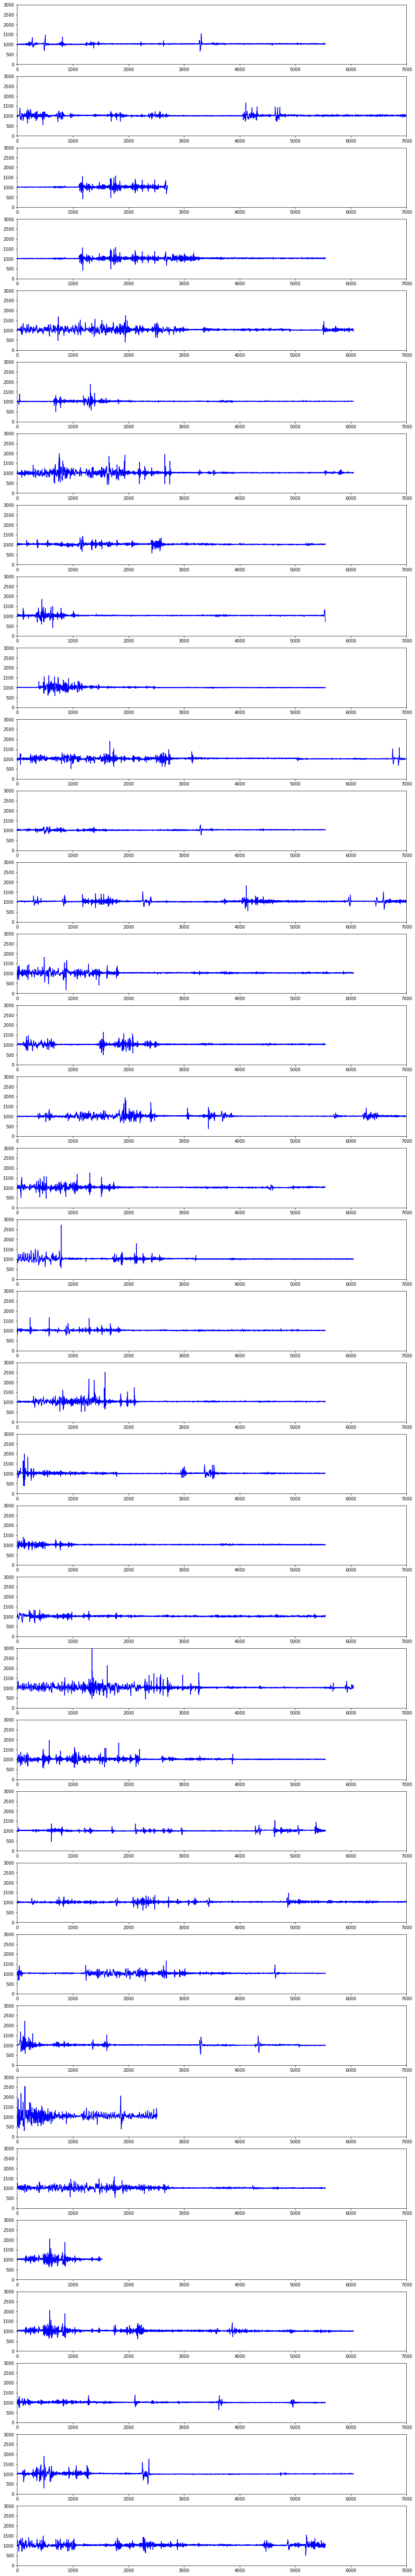

In [11]:
# Plotting the magnitude arrays for a random ET sample

et_sample = samples['ET'][3]
et_sample_data = []
for file_path in get_file_names(et_sample,datadir):
    with open(file_path,'rb') as inp:
            movement_data = pickle.load(inp)
            movement_data = np.array(movement_data)
        
    et_sample_data.append(movement_data)
    
print('{}: Number gameplays = {}'.format(et_sample, len(et_sample_data)))
n = len(et_sample_data)
fig = plt.figure(figsize=(16,3*n))

for i in range(1,n+1):
    ax = fig.add_subplot(n,1,i)
    ax.plot(et_sample_data[i-1],'b')
    ax.set_xlim([0,7000])
    ax.set_ylim([0,3000])
    
plt.show()
plt.close()

# 2. Analysis

### Butterworth Bandpass filter

In [12]:
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, sf, order):
    ''' sf = sampling frequency in Hz '''
    
    nyq = 0.5*sf
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, sf, order):
    ''' sf = sampling frequency in Hz
        lowcut = lower cutoff for frquency
        highcut = upper cutoff for frequency'''
    
    b, a = butter_bandpass(lowcut, highcut, sf, order=order)
    y = lfilter(b, a, data)
    return y

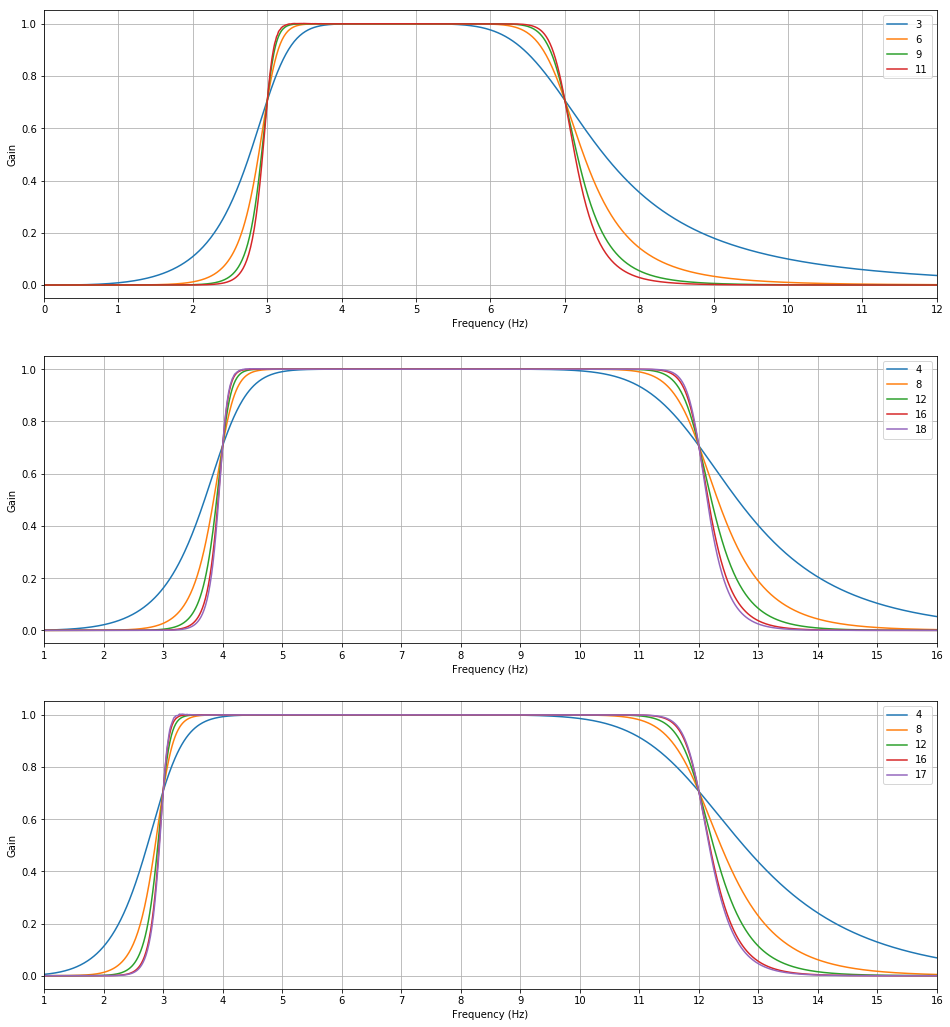

In [13]:
# Sample rate (fs) and desired cutoff frequencies (lowcut,highcut) (in Hz).

fig = plt.figure(figsize=[16,18])

ax = fig.add_subplot(3,1,1)
fs = 50.0
lowcut = 3.0
highcut = 7.0

# Plot the frequency response for a few different orders.

orders = [3, 6, 9, 11]
for order in orders:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    ax.set_xticks(range(26))
    ax.set_xlim([0,12])
    ax.grid(True)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.grid(True)
    
    ax.legend(orders)

ax = fig.add_subplot(3,1,2)
lowcut = 4
highcut = 12

orders = [4, 8, 12, 16, 18]
for order in orders:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    ax.set_xticks(range(26))
    ax.set_xlim([1,16])

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.grid(True)
    
    ax.legend(orders)

    
ax = fig.add_subplot(3,1,3)
lowcut = 3
highcut = 12

orders = [4, 8, 12, 16, 17]
for order in orders:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    ax.set_xticks(range(26))
    ax.set_xlim([1,16])

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain')
    ax.grid(True)
    
    ax.legend(orders)

    
plt.show()
plt.close()

### Tremor Level


In [14]:
def tremor_filter(data, tremor_type, sampling_frequency = 50):
    
    if tremor_type == 'pd':
        low, high, order = 3,7,11
    elif tremor_type == 'et':
        low, high, order = 4,12,18
    elif tremor_type == 'comb':
        low, high, order = 3,12,17
    else:
        raise Exception('Unknown tremor type.')
    
    filtered_data = butter_bandpass_filter(data, low, high, sampling_frequency, order)
    
    return filtered_data


# Summary metrics

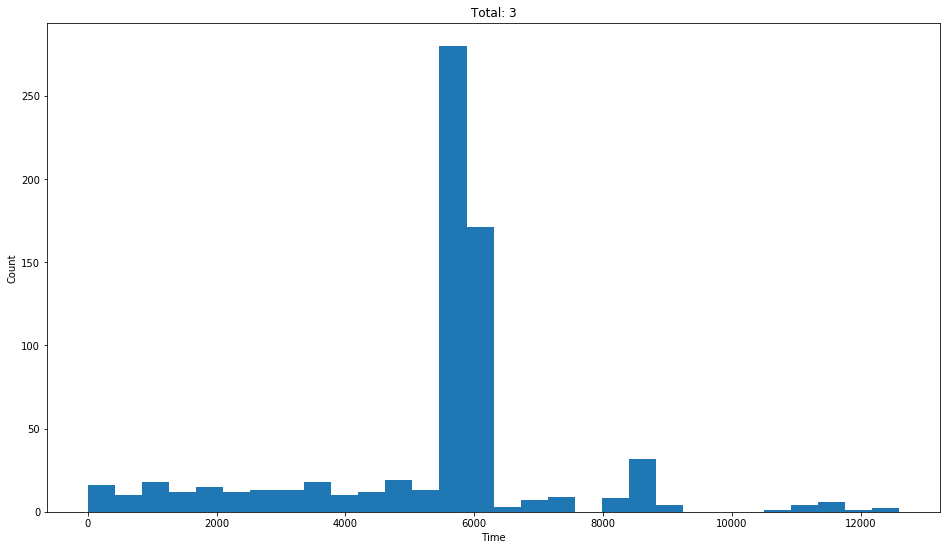

In [15]:
# Filter out gameplays which are too short or too long

data_length = []
for i in et_data+pd_data:
    length = len(i)
    data_length.append(length)

fig = plt.figure(figsize=(16,9))
plt.hist(data_length,bins=30)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Total: {}'.format(len(temp)))
plt.show()
plt.close()

In [16]:
et_data_2 = []
for i in et_data:
    if not (len(i)<4000 or len(i)>7500):
        et_data_2.append(i)

pd_data_2 = []
for i in pd_data:
    if not (len(i)<4000 or len(i)>7500):
        pd_data_2.append(i)
        
et_data = et_data_2
pd_data = pd_data_2

In [17]:
et_stats = {'Energy':{'comb':[],'et':[],'pd':[]},
            'Average Amplitude':{'comb':[],'et':[],'pd':[]},
            'Max Amplitude':{'comb':[],'et':[],'pd':[]}}

for data in et_data:
    
    pd_filt = np.absolute(tremor_filter(data,tremor_type='pd'))
    et_filt = np.absolute(tremor_filter(data,tremor_type='et'))
    comb_filt = np.absolute(tremor_filter(data,tremor_type= 'comb'))
    
    et_stats['Energy']['comb'].append(sum(comb_filt))
    et_stats['Energy']['et'].append(sum(et_filt))
    et_stats['Energy']['pd'].append(sum(pd_filt))
    
    et_stats['Average Amplitude']['comb'].append(sum(comb_filt)/len(comb_filt))
    et_stats['Average Amplitude']['et'].append(sum(et_filt)/len(et_filt))
    et_stats['Average Amplitude']['pd'].append(sum(pd_filt)/len(pd_filt))
    
    et_stats['Max Amplitude']['comb'].append(max(comb_filt))
    et_stats['Max Amplitude']['et'].append(max(et_filt))
    et_stats['Max Amplitude']['pd'].append(max(pd_filt))
    

pd_stats = {'Energy':{'comb':[],'et':[],'pd':[]},
            'Average Amplitude':{'comb':[],'et':[],'pd':[]},
            'Max Amplitude':{'comb':[],'et':[],'pd':[]}}

for data in pd_data:
    pd_filt = np.absolute(tremor_filter(data,tremor_type='pd'))
    et_filt = np.absolute(tremor_filter(data,tremor_type='et'))
    comb_filt = np.absolute(tremor_filter(data,tremor_type= 'comb'))
    
    pd_stats['Energy']['comb'].append(sum(comb_filt))
    pd_stats['Energy']['et'].append(sum(et_filt))
    pd_stats['Energy']['pd'].append(sum(pd_filt))
    
    pd_stats['Average Amplitude']['comb'].append(sum(comb_filt)/len(comb_filt))
    pd_stats['Average Amplitude']['et'].append(sum(et_filt)/len(et_filt))
    pd_stats['Average Amplitude']['pd'].append(sum(pd_filt)/len(pd_filt))
    
    pd_stats['Max Amplitude']['comb'].append(max(comb_filt))
    pd_stats['Max Amplitude']['et'].append(max(et_filt))
    pd_stats['Max Amplitude']['pd'].append(max(pd_filt))
    


# Plots of summary metrics

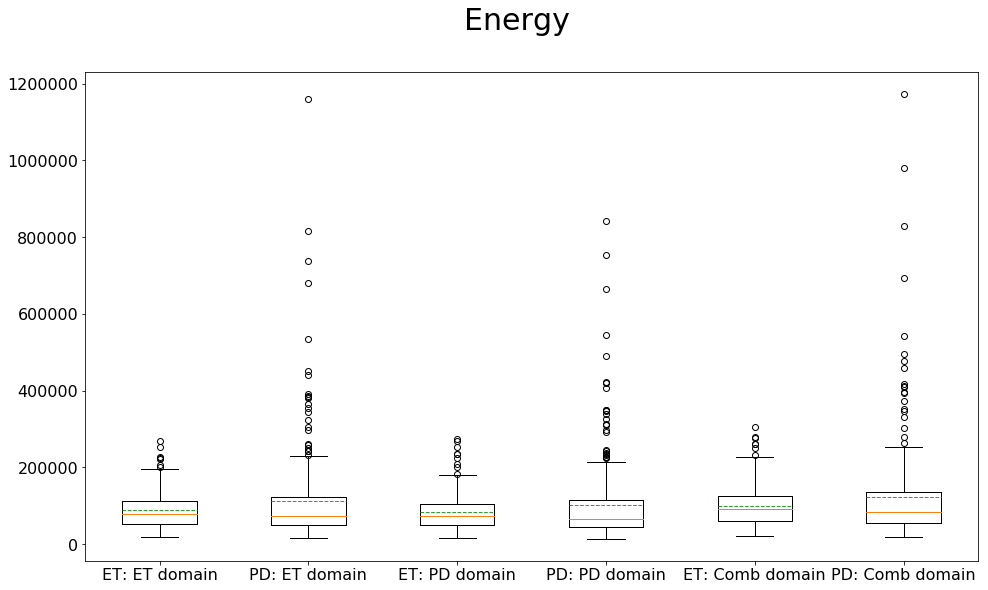

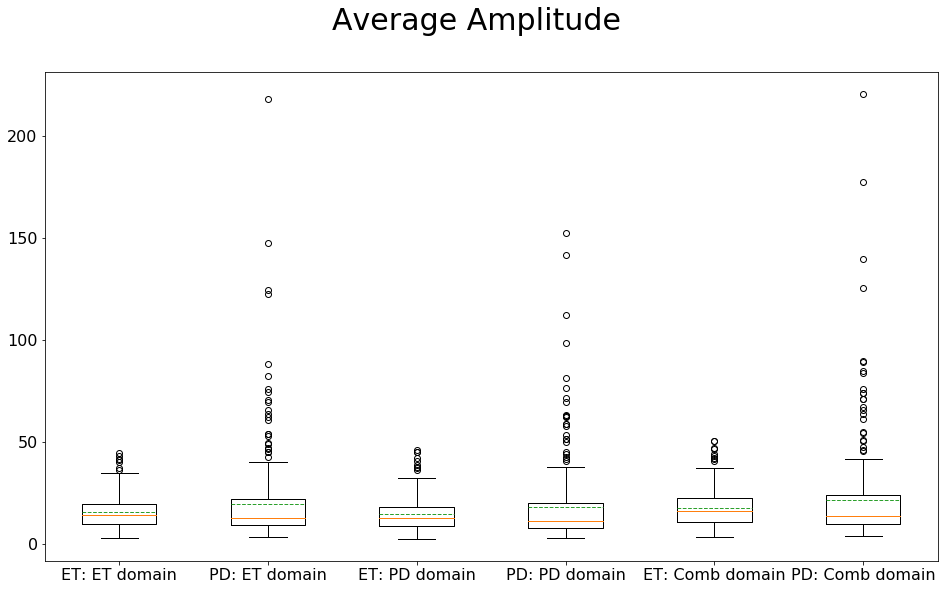

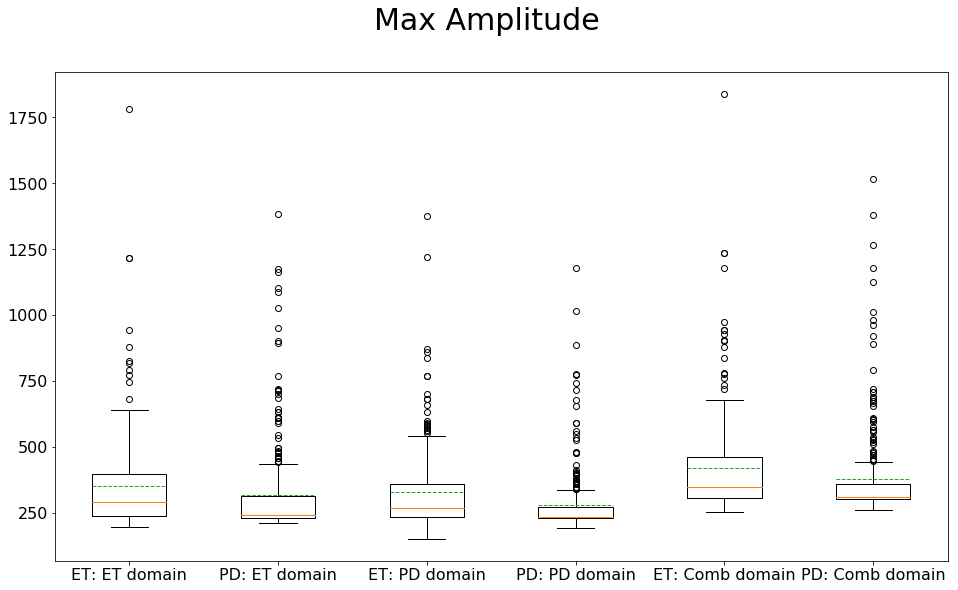

In [18]:
# Plots for ET and PD wavelength spectrums

for plot_data_type in ['Energy','Average Amplitude','Max Amplitude']:

    fig = plt.figure(figsize=(16,9))
    
    labelsize = 16
    rcParams['xtick.labelsize'] = labelsize
    rcParams['ytick.labelsize'] = labelsize 

    data_array = [ et_stats[plot_data_type]['et'], pd_stats[plot_data_type]['et'], 
                   et_stats[plot_data_type]['pd'], pd_stats[plot_data_type]['pd'], 
                   et_stats[plot_data_type]['comb'], pd_stats[plot_data_type]['comb']]
                   
    data_label = ['ET: ET domain', 'PD: ET domain', 
                  'ET: PD domain', 'PD: PD domain', 
                  'ET: Comb domain', 'PD: Comb domain']
                  
    
    plt.boxplot(data_array, labels=data_label,
               showmeans = True, meanline=True, showfliers=True)
    plt.suptitle(plot_data_type, fontsize=30)
    plt.savefig(plot_data_type.replace(' ','_')+'_filtered_data.png',format='png')
 
    plt.show()
    plt.close()

## t-tests for summary metrics

In [19]:
for data_type in ['Energy','Average Amplitude','Max Amplitude']:
    
    print(data_type,'\n')
    for frequency_range in ['et','pd','comb']:
    
        print('{} Frequencies'.format(frequency_range.upper()))
        et_data_arr = et_stats[plot_data_type][frequency_range]
        pd_data_arr = pd_stats[plot_data_type][frequency_range]
    
        print('Mean ET:{res1:.3E}, Mean PD:{res2:.3f}'.format(res1=np.mean(et_data_arr), 
                                                                  res2=np.mean(pd_data_arr)) )
        #print('Var  ET:{res1:.3E}, Var PD:{res2:.3f}'.format(res1=np.var(et_data_arr), 
        #                                                          res2=np.var(pd_data_arr)) )
        
        t,p = stats.ttest_ind(et_data_arr, pd_data_arr, equal_var=False)
        print('t:{}, p-value:{res:.3E}'.format(round(t,3), res=p))
        print('\n')
    
    print('\n')
    

Energy 

ET Frequencies
Mean ET:3.522E+02, Mean PD:316.770
t:2.191, p-value:2.889E-02


PD Frequencies
Mean ET:3.278E+02, Mean PD:280.136
t:3.754, p-value:1.978E-04


COMB Frequencies
Mean ET:4.192E+02, Mean PD:378.676
t:2.446, p-value:1.479E-02




Average Amplitude 

ET Frequencies
Mean ET:3.522E+02, Mean PD:316.770
t:2.191, p-value:2.889E-02


PD Frequencies
Mean ET:3.278E+02, Mean PD:280.136
t:3.754, p-value:1.978E-04


COMB Frequencies
Mean ET:4.192E+02, Mean PD:378.676
t:2.446, p-value:1.479E-02




Max Amplitude 

ET Frequencies
Mean ET:3.522E+02, Mean PD:316.770
t:2.191, p-value:2.889E-02


PD Frequencies
Mean ET:3.278E+02, Mean PD:280.136
t:3.754, p-value:1.978E-04


COMB Frequencies
Mean ET:4.192E+02, Mean PD:378.676
t:2.446, p-value:1.479E-02






## Make Dataframe

In [21]:
# Tremors run through bandpass for PD frequency range as it had the most significant difference in means

dataframe = {'energy':[],'avg_amp':[],'max_amp':[],'tremor':[],'sampID':[]}

for tremor in ['ET','PD']:
    for samp in samples[tremor]:
        for file_path in get_file_names(samp,datadir):
            with open(file_path,'rb') as inp:
                movement_data = pickle.load(inp)
                movement_data = np.array(movement_data)
            
            if not (len(movement_data)<4000 or len(movement_data)>7500):
                et_filtered = np.absolute(tremor_filter(movement_data,tremor_type= 'pd'))

                dataframe['energy'].append(sum(et_filtered))
                dataframe['avg_amp'].append(sum(et_filtered)/len(et_filtered))
                dataframe['max_amp'].append(max(et_filtered))
                dataframe['tremor'].append(tremor)        
                dataframe['sampID'].append(samp)

dataframe = DataFrame(dataframe)
                                    
# Write the df
print(dataframe.shape)
dataframe.to_csv(path_or_buf='gameplay_data_metrics.csv',header=True,index=False)

(511, 5)
